E9.project_My_First_Kaggle
===
---

나의 생애 첫번째 캐글대회에 참가해보자!

![kaggle](https://user-images.githubusercontent.com/70703320/108371313-fa6f3e80-7240-11eb-9269-f2da4ee7675e.png)


데이터 정보: [2019 2nd ML month with KaKR](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)

## 1.  데이터를 위한 준비과정

#### 시각화를 위한 라이브러리

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### 필요한 라이브러리 import 하기

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

#### 로컬에서 사용할 파일 경로

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

#### train, test 데이터 지정해주기

In [4]:
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

#### 컬럼 확인하기

In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### date에서 날짜만 빼내어오기

In [6]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### price 컬럼을 y라는 변수에 저장한 후 price 컬럼삭제

In [7]:
y = train['price']
del train['price']

#### id 컬럼 지워주기

In [8]:
del train['id']

#### test데이터에 대해서도 적용 하지만 price에 대해서는 적용할 필요가 없다.

In [9]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

## 2. EDA 및 visulization

#### 결측치 확인 시각화

<AxesSubplot:>

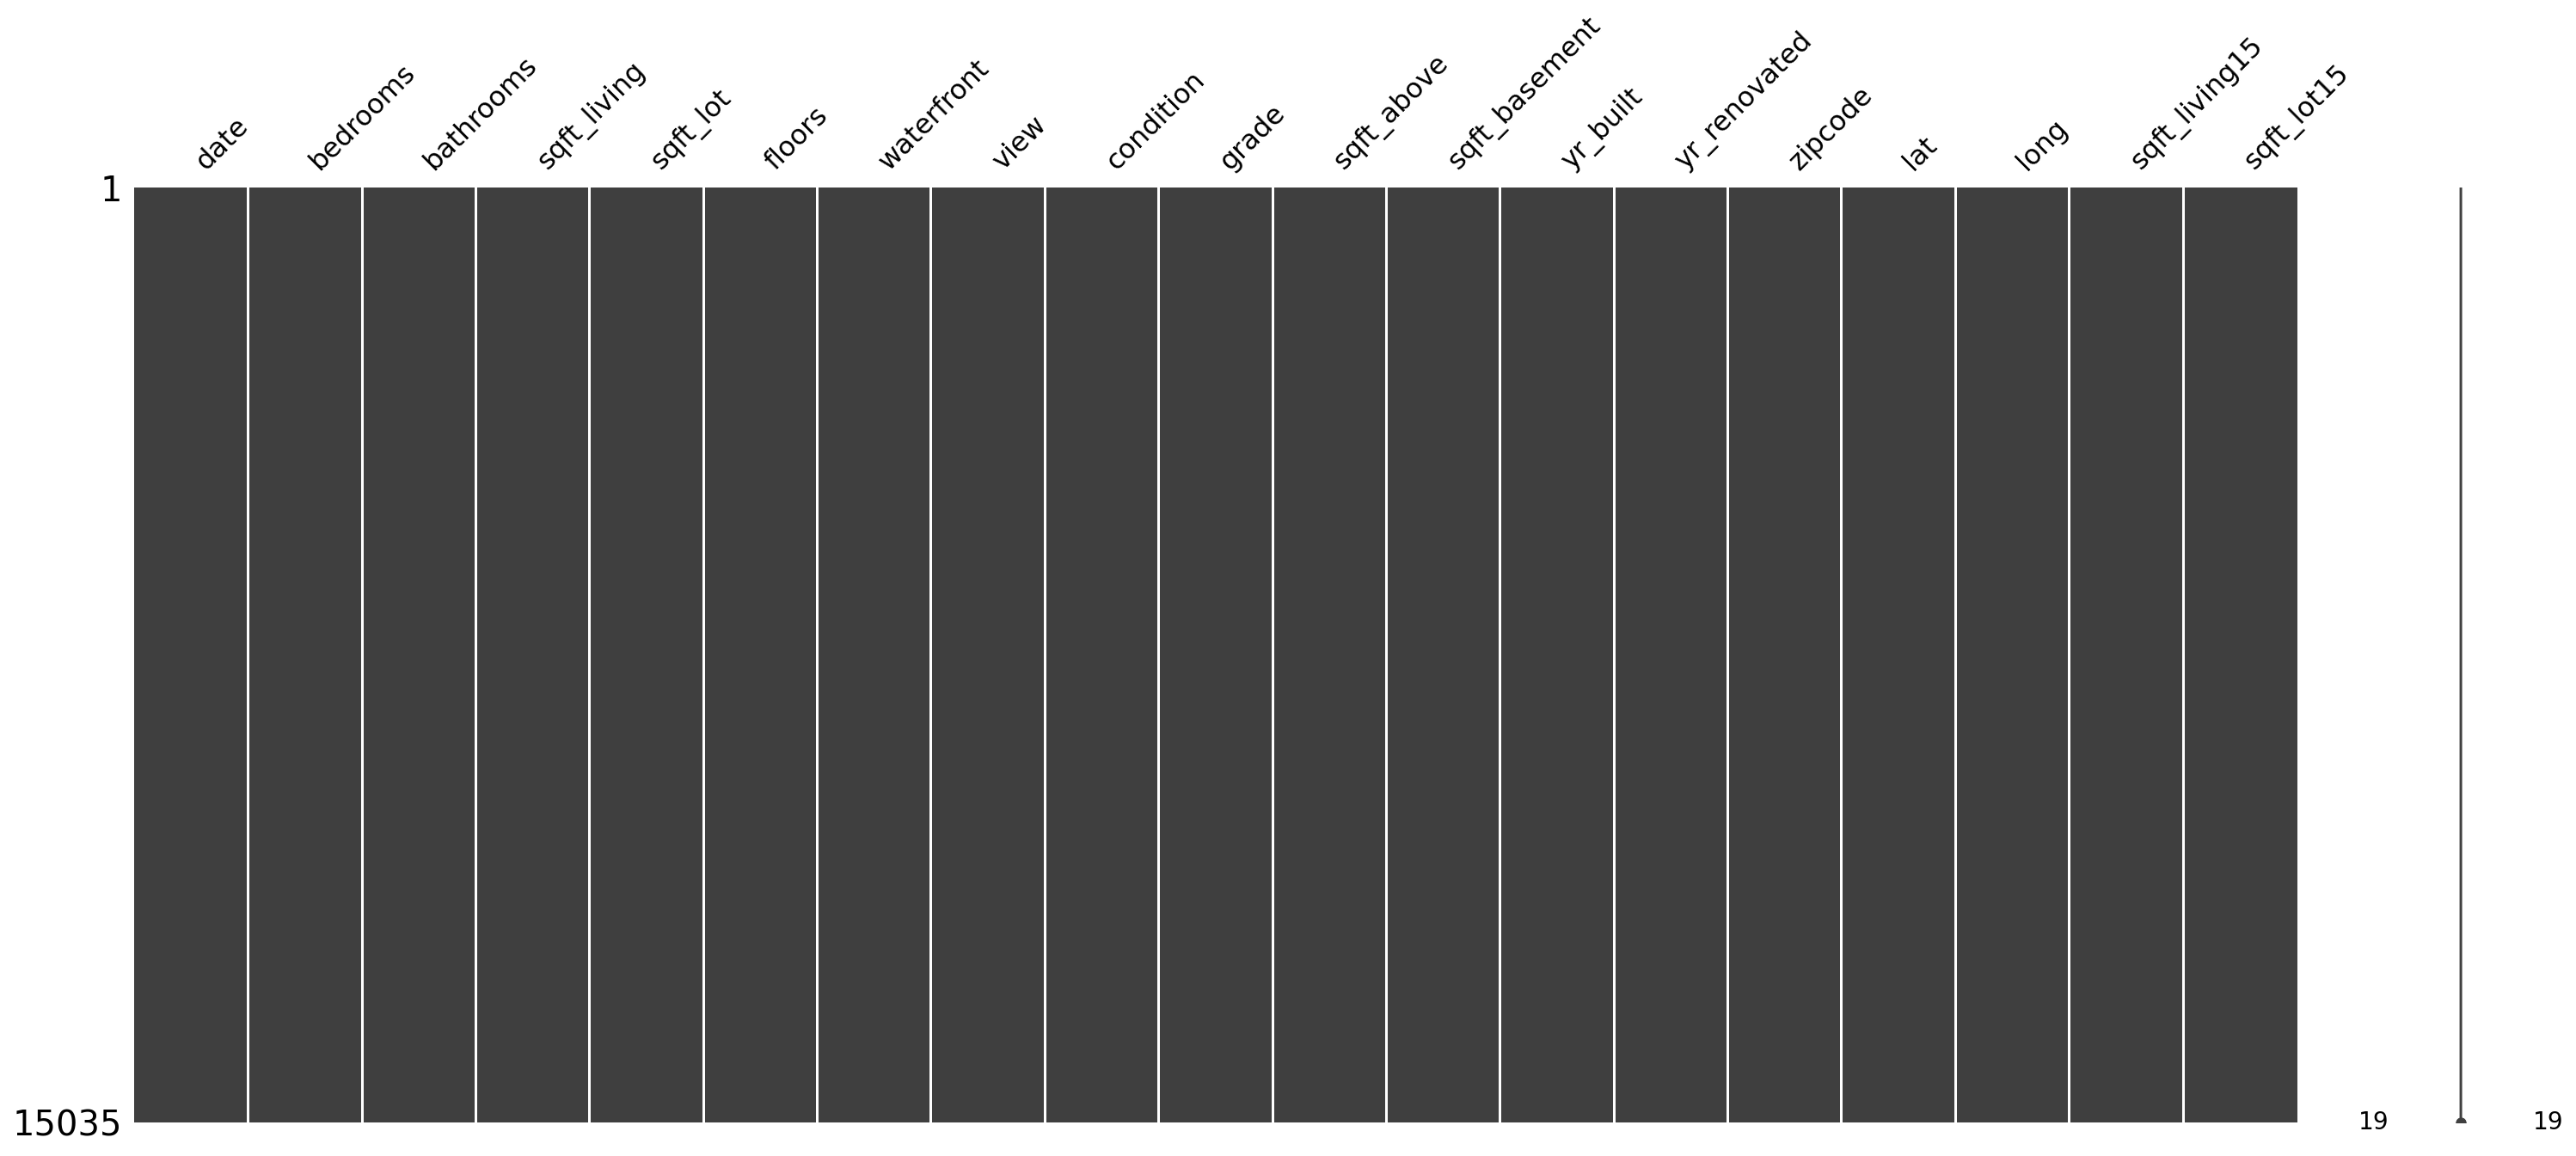

In [10]:
msno.matrix(train)

#### 결측치를 출력하여 확인

In [11]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


#### 전체 그래프 그려보기

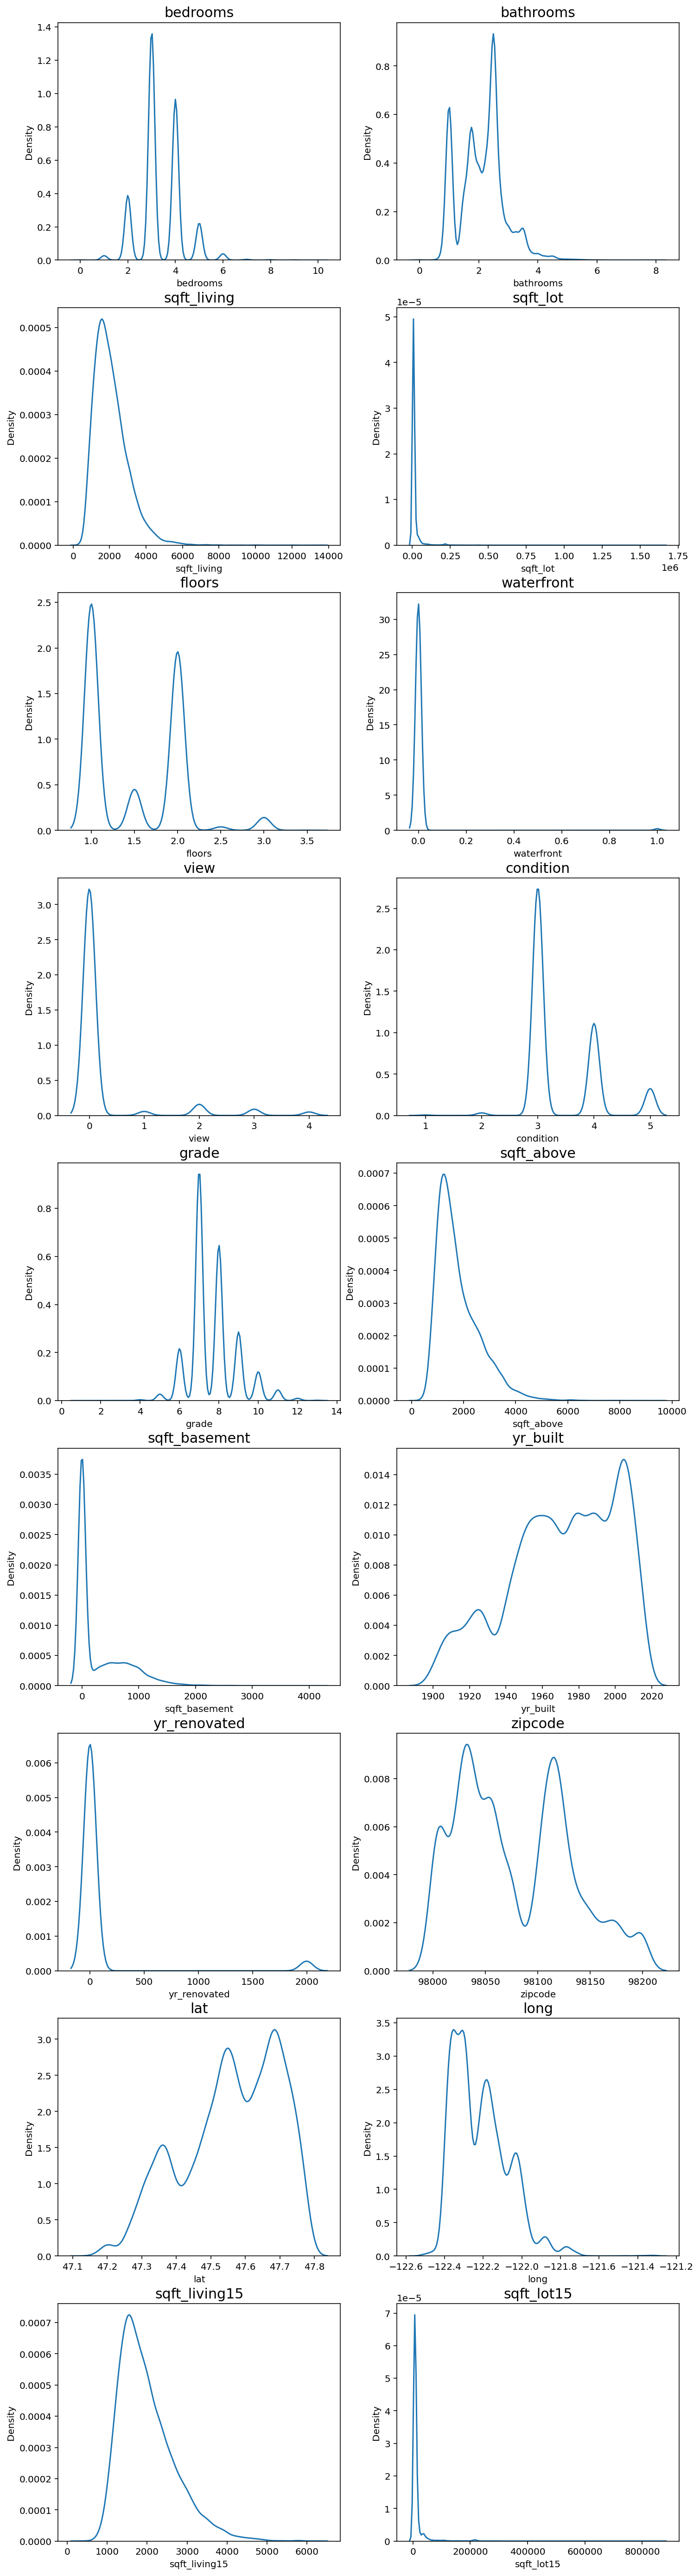

In [12]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   

count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

#### 왼쪽으로 치우친 분포들(왜도가 양의 값을 갖는 경우)로그변환 해주기

In [13]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

#### 변환된 분포 확인해보기

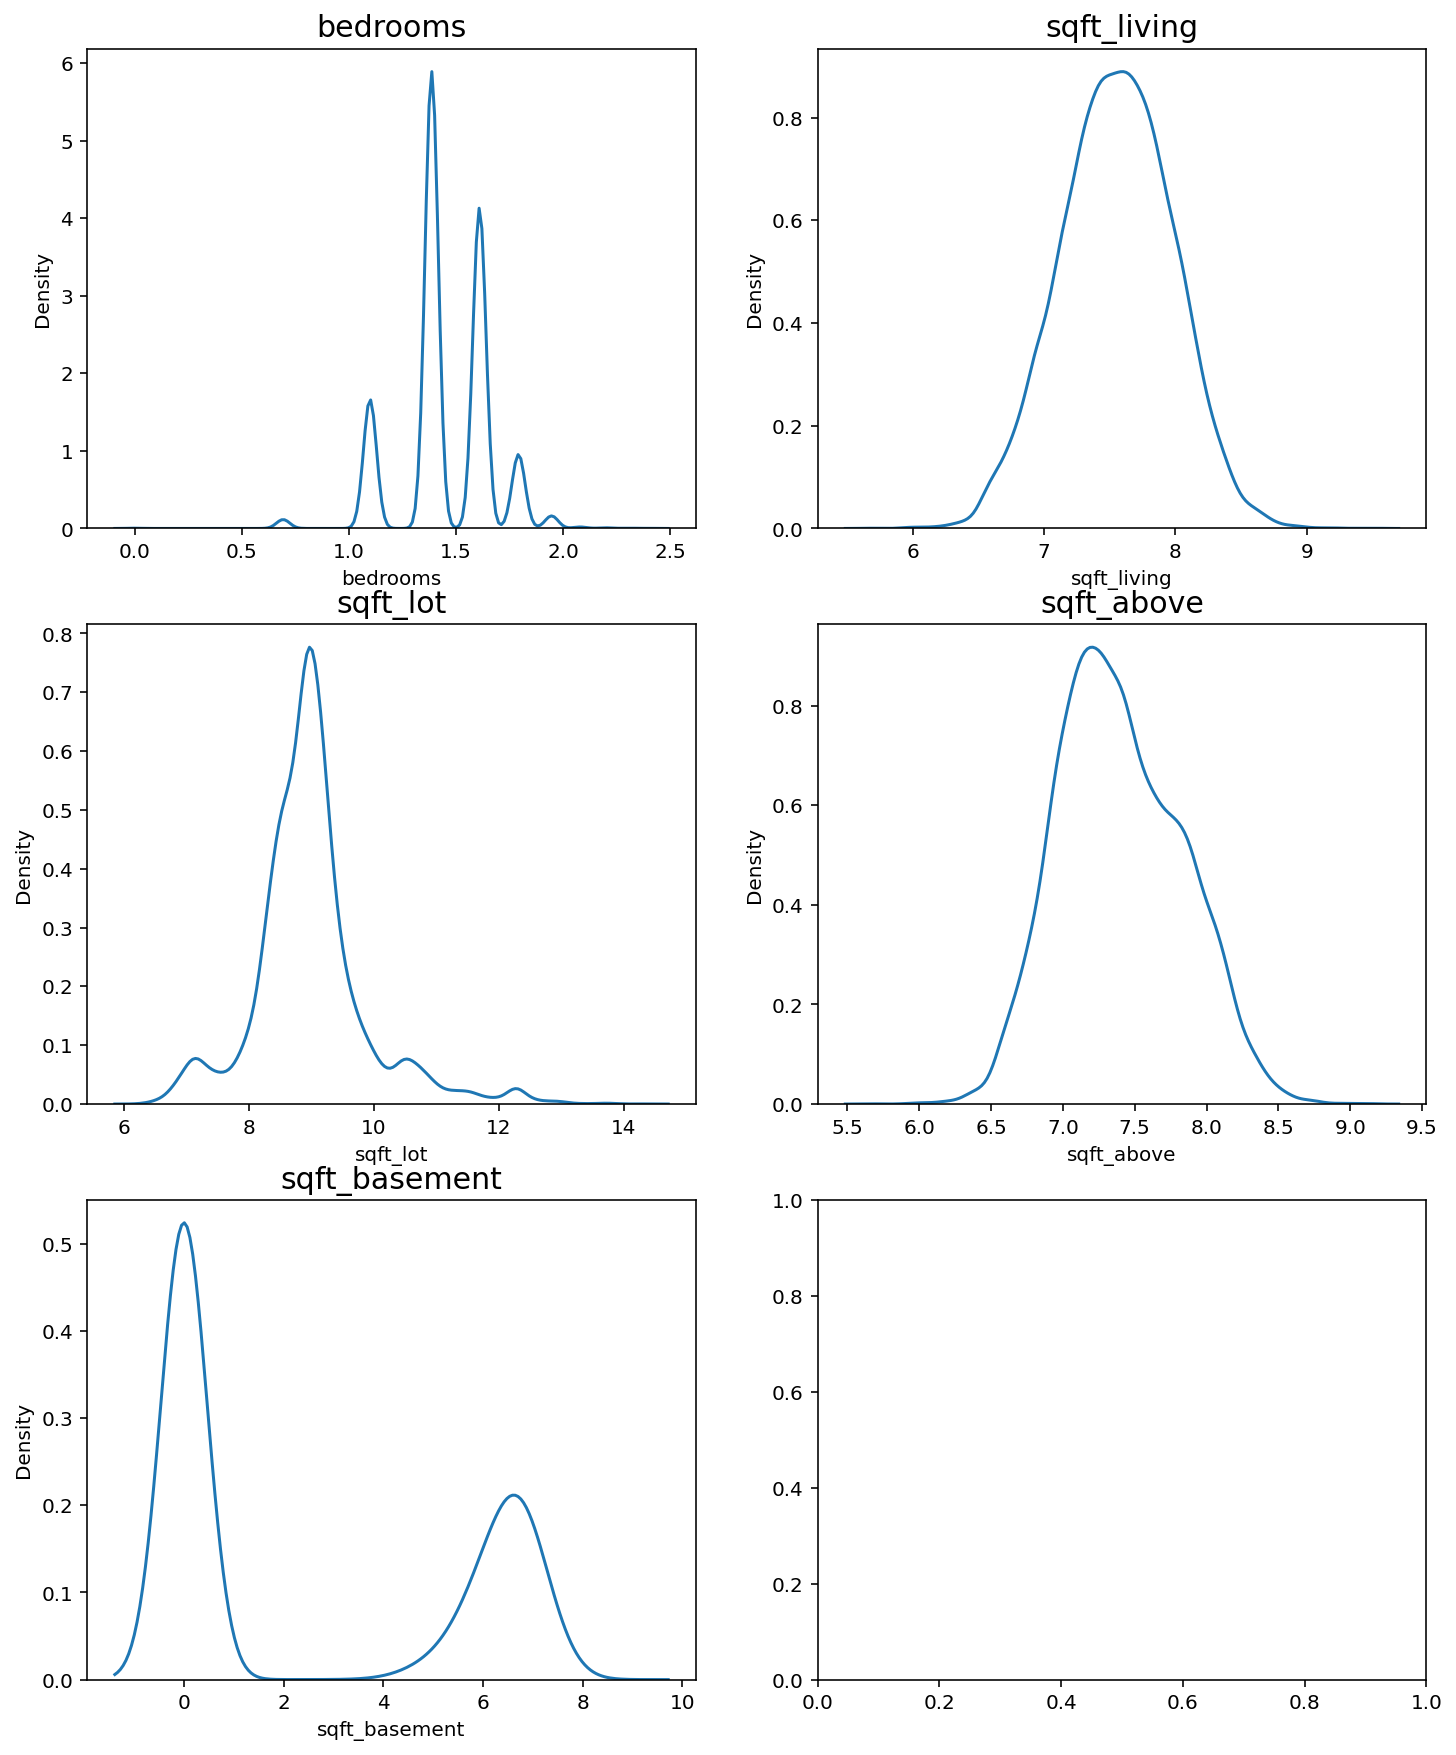

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

#### y인 price의 분포 확인해보기

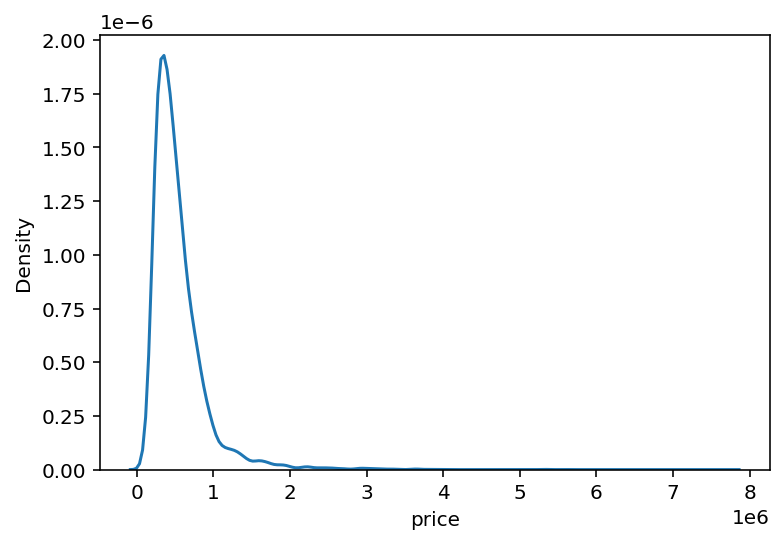

In [15]:
sns.kdeplot(y)
plt.show()

#### data의 price의 분포 로그 변환 후 확인해보기

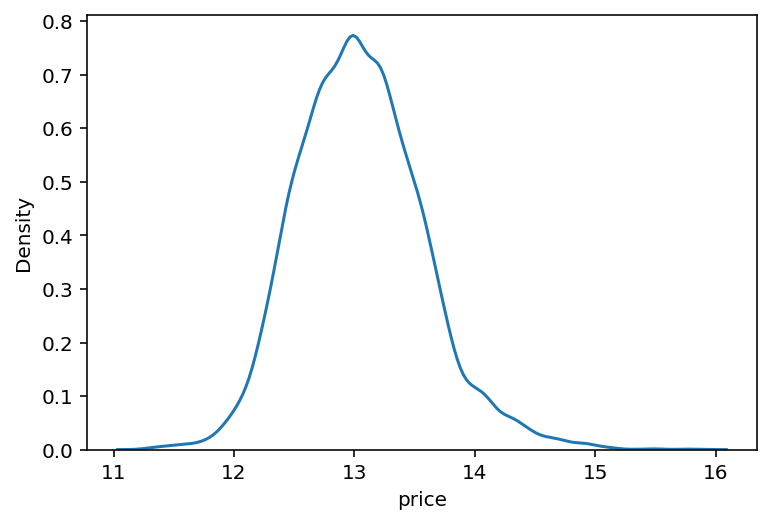

In [16]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

#### 전체데이터의 자료형을 한 눈에 확인

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

> 모든 값이 실수 또는 정수형이므로 모델 학습에 사용이 가능할 듯 하다.

## 3. 모델 준비하기

#### RMSE점수를 계산하기 위한 라이브러리 불러오기

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


#### rmse 함수 정의 (y_test나 y_pred는 위에서 로그변환을 해주었기 때문에 역으로 변환 해주어야 함)

In [19]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


#### XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델

In [20]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

#### random_state를 설정해두고 모델들 설정

In [21]:
random_state=2020    

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#### 모델의 속성을 얻기 위해서는 클래스의 __name___ 속성에 접근해서 얻을 수 있다.

In [22]:
gboost.__class__.__name__

'GradientBoostingRegressor'

#### 각 모델들의 속성을 얻어보기

In [23]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

#### GridSearchCV 클래스를 활용하기

In [24]:
from sklearn.model_selection import GridSearchCV

> GridSearchCV에 입력되는 인자들
>
> - param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
> - scoring : 모델의 성능을 평가할 지표
> - cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
> - verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
> - n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수
>
> param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비

GridSearchCV를 이용해서 grid_model 모델을 초기화하고, train과 y 데이터로 모델을 간단히 학습

#### 모델 정리하는 함수만들기

In [25]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)
    model.fit(train, y)
    params = model.cv_results_['params']
    score = model.cv_results_['mean_test_score']
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSE'] = np.sqrt(-1 * results['score'])
    results = results.rename(columns={'RMSE': 'RMSLE'})
    results = results.sort_values('RMSLE')
    return results

#### 그리드 탐색을 위한 설정 후 함수 적용해보기

In [26]:
param_grid = {
    'n_estimators': [1, 100, 200, 300],
    'max_depth': [1, 10, 20, 30]
}


## 4. 모델들 rmse 확인


#### gboost모델

In [27]:
my_GridSearch(gboost, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   48.5s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  3.5min finished


,max_depth,n_estimators,score,RMSLE
7,10,300,-1.764082e+10,132818.749717
6,10,200,-1.765712e+10,132880.079265
5,10,100,-1.769594e+10,133026.076951
9,20,100,-3.022447e+10,173851.859483
11,20,300,-3.022480e+10,173852.820288
10,20,200,-3.022480e+10,173852.820317
3,1,300,-3.022687e+10,173858.768625
2,1,200,-3.232824e+10,179800.566548
13,30,100,-3.271587e+10,180875.296830
14,30,200,-3.271661e+10,180877.343657


#### xgboost모델

In [28]:
my_GridSearch(xgboost, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  6.6min finished


,max_depth,n_estimators,score,RMSLE
5,10,100,-1.793283e+10,133913.498405
6,10,200,-1.793873e+10,133935.546487
7,10,300,-1.794099e+10,133943.973623
11,20,300,-1.878007e+10,137040.407772
10,20,200,-1.878008e+10,137040.438100
9,20,100,-1.878009e+10,137040.476569
15,30,300,-1.880353e+10,137125.980764
14,30,200,-1.880355e+10,137126.040380
13,30,100,-1.880357e+10,137126.100740
3,1,300,-2.881780e+10,169758.051694


#### lightgbm모델

In [29]:
my_GridSearch(lightgbm, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:   20.0s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   49.5s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,max_depth,n_estimators,score,RMSLE
10,20,200,-1.617851e+10,127194.778027
7,10,300,-1.620135e+10,127284.506759
14,30,200,-1.621492e+10,127337.831218
6,10,200,-1.623858e+10,127430.670447
11,20,300,-1.629955e+10,127669.685183
9,20,100,-1.632403e+10,127765.512631
13,30,100,-1.632403e+10,127765.512631
15,30,300,-1.633407e+10,127804.813982
5,10,100,-1.636424e+10,127922.786707
3,1,300,-3.069994e+10,175213.985199


#### rdforest모델

In [30]:
my_GridSearch(rdforest, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:   44.1s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  2.2min finished


,max_depth,n_estimators,score,RMSLE
15,30,300,-1.788271e+10,133726.266157
11,20,300,-1.801140e+10,134206.569046
14,30,200,-1.801384e+10,134215.652084
9,20,100,-1.802270e+10,134248.653201
13,30,100,-1.807633e+10,134448.247756
10,20,200,-1.809689e+10,134524.679929
7,10,300,-1.944775e+10,139455.192257
6,10,200,-1.955733e+10,139847.510230
5,10,100,-1.969103e+10,140324.723177
4,10,1,-3.583543e+10,189302.479958


> 결과를 살펴보니 lightgbm 모델이 가장 RMSLE값이 적게 나오는 것을 확인할 수 있었다.
이때의 max_depth는 20, n_estimators는 200이었다.

## 5. 결과 저장하기

#### 저장하는 함수

In [31]:
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.1')
    submission.to_csv(submission_csv_path, index=False)
    return submission_csv_path

#### 파일 저장하기

In [32]:
save_submission(lightgbm, train, y, test, 'lightgbm', rmsle='0.1')

'/home/aiffel-dj63/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.1.csv'

### 회고

- 다양한 EDA과정과 시각화기법의 단련
    - 결측치가 있는지 확인하고 각 변수들마다 시각화를 통해 Log변환이 필요한지 살펴보는 과정을 배울 수 있었다.

- 여러 모델들 비교하는 것의 어려움
    - 여러 모델들을 grid search로 학습하는 것이 시간이 오래걸린다는 어려움이 있었다. 추가로 모델들이 my_GridSearch()함수를 한꺼번에 돌 수 있도록 설계를 해보았었는데 RMSE를 비교하는 표가 뜨지 않아 실패하였다. 그래서 따로 한 번씩 돌려보기로 하였다.
    

### 루브릭

- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
    - 실행순서를 보면 쭈욱 한 번에 진행되었다.
    
    
- 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
    - 체계적으로 기술해보았다.
    
    
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?
